<a href="https://colab.research.google.com/github/HackaGeo2021UFF/desafio-amarracao-poco/blob/main/support/well_tie_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amarração Sísmica-Poço

In this module, you learn how you can use Python to perform the well-tie calculus.

# Part 1 - Preparation

## Install necessary packages

To install a package in `Google Colab`, you need to execute the following command:

`!pip install package`, as in `!pip install segysak`.

For this lesson, you will need:
* `lasio`: learn more about it [here](https://lasio.readthedocs.io/en/latest/)
* `welly`: learn more about it [here](https://github.com/agile-geoscience/welly)
* `gitpython`: learn more about it [here](https://github.com/gitpython-developers/GitPython)

In [1]:
!pip install gitpython
!pip install welly
!pip install lasio
!pip install wellpathpy

     |████████████████████████████████| 180 kB 19.3 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 77 kB 7.4 MB/s 
  Created wheel for welly: filename=welly-0.4.10-py3-none-any.whl size=56037 sha256=7be7bff01a4c15282d8faf9f40de6a93f796ea63a131af293303d26fdd69d9a7
  Stored in directory: /root/.cache/pip/wheels/e6/cf/9f/7d1cc15079dbecf27bb332a36574907bf3c394371774c4ab49
  Created wheel for striplog: filename=striplog-0.8.8-py3-none-any.whl size=83652 sha256=d7793b268750d387d2cc723347e8d9c46eba9c75e950bf4f6217c5d1f96e7ff3
  Stored in directory: /root/.cache/pip/wheels/c9/c1/35/ca8f6fc79aafef514edc14a8f4546efbcf92a943b9e7943810
Successfully built welly striplog


## Demo Data

The demo data can be found in [here](https://github.com/aruss175/transform_2020_intro_viz/tree/master/data) but you don't need to download it. There is a cell to do it for you.

In [2]:
# download the data
import git
git.Git("/content").clone("https://github.com/mardani72/Synthetic_Seismogram.git")

''

# Part 2 - Well-tie calculus

Synthetic seismograms can be created by doing basic calculus on travel-time functions. Integrating slowness (the reciprocal of velocity) can a yield a time-to-depth relationship for making a well tie. Differentiating an acoustic impedance (velocity times density) log yields a reflectivity function along the borehole, which can be convolved with a seismic wavelet. In effect, the integral tells us where a given interval of rock is in the time-domain, the derivative tells us what it should look like; its seismic character.

## Generating Synthetic Seismogram in Python
#### Seven steps to generate seismogram from well logs
[Ryan A. Mardani](https://www.linkedin.com/in/amardani/)

In this project, synthetic seismogram will be generated using sonic and density well logs. To recognize formation tops on seismic profiles (horizons), we mainly rely on well data. Well data includes petrophysical well logs and geological interpretation such as key formation boundries. Tying well data on seismic data is more percise if we generate synthetic seismogram. 

Some steps are required to generate seismogram:<br>
1- Data Preparation (Unit conversion and Sonic / Density Logs processing) <br>
2- Time-Depth relationship construction<br>
3- Acoustic Impedance(AI or Z) Calculation, AI (product of sonic wave velocity and medium density)<br>
4- Reflection Coefficient(Rc) calculation<br>
5- Resampling to the time domain and Rc recalculation<br>
6- Wavelet & Convolution<br>
7- Visualization<br>

# Part 3 - Coding it!

## 1- Data Prepration

We will implemet some data operation (like smoothing/despiking) using welly library developed by [agile geoscience](https://agilescientific.com) team. 

In [3]:
import welly
from welly import Well
import pandas as pd
import lasio
import numpy as np

In [4]:
w_path = '/content/Synthetic_Seismogram/KK1.las'
w = Well.from_las(w_path)
# w.header                      # runing with welly lib we are not able to see las header data
w_las= lasio.read(w_path) # lasio lib will help
w_las.header

/usr/local/lib/python3.7/dist-packages/welly/well.py:194: FutureWarning: From v0.5 the default will be 'original', keeping whatever is used in the LAS file. If you want to force conversion to metres, change your code to use `index='m'`.
  warnings.warn(m, FutureWarning)
/usr/local/lib/python3.7/dist-packages/welly/curve.py:216: UserWarning: Irregular sampling in depth is not supported. Interpolating to regular basis.
  warnings.warn(m)


{'Curves': [CurveItem(mnemonic="DEPT", unit="m", value="", descr="DEPTH", original_mnemonic="DEPT", data.shape=(19405,)),
  CurveItem(mnemonic="DT", unit="us/ft", value="", descr="DT", original_mnemonic="DT", data.shape=(19405,)),
  CurveItem(mnemonic="RHOB", unit="g/cm3", value="", descr="RHOB", original_mnemonic="RHOB", data.shape=(19405,)),
  CurveItem(mnemonic="SW", unit="m3/m3", value="", descr="SW", original_mnemonic="SW", data.shape=(19405,)),
  CurveItem(mnemonic="PHIE", unit="m3/m3", value="", descr="PHIE", original_mnemonic="PHIE", data.shape=(19405,))],
 'Other': '',
 'Parameter': [],
 'Version': [HeaderItem(mnemonic="VERS", unit="", value="2.0", descr="CWLS LOG ASCII STANDA"),
  HeaderItem(mnemonic="WRAP", unit="", value="NO", descr="SINGLE LINE PER DEPTH "),
  HeaderItem(mnemonic="CREA", unit="", value="8/24/2012 12:51", descr="22")],
 'Well': [HeaderItem(mnemonic="STRT", unit="m", value="1517.0", descr="START DEPTH"),
  HeaderItem(mnemonic="STOP", unit="m", value="3850.70

#### Unit Conversion

To calculate Acoustic Impedance, we need to have Sonic log (DT) in µs/m unit as well as density log (RHOB) in kg/m3. Looking at header: DT has us/ft unit and RHOB g/cm3. 

In [5]:
w.data['DT'] = w.data['DT'] / 0.3048   #unit convert to µs/m
w.data['RHOB'] = w.data['RHOB'] * 1000  #unit convert to kg/m3

#### Despiking & Smoothing

Spikes are common on well logs, especially on sonic measurements. These spikes are not the true representative of rock properties variation through the well intervals and need to be eliminated.

In [6]:
#Despiking
#Sonic Despiking
dt = w.data['DT']
w.data['DT_DS'] = dt.despike(window_length=50, z=2)

#Density Despiking
den = w.data['RHOB']
w.data['RHOB_DS'] = den.despike(window_length=50, z=2)


We will input despiked data to be smoothed:

In [7]:
#Smoothing 
#Sonic Smoothing
dt_ds = w.data['DT_DS']
w.data['DT_DS_SM'] = dt_ds.smooth(window_length=10, samples=False)

#Density Smoothing
den_ds = w.data['RHOB_DS']
w.data['RHOB_DS_SM'] = den_ds.smooth(window_length=10, samples=False)

## 2- Time-Depth relationship 

Seismic data is measured in the time domain while well data mainly have depth domain. To convert time to depth and vice versa, we need to establish a relationship. There are several ways to do this but here, as we use the sonic log, which is reciprocal of sound wave velocity. Mathematically if we integrate DT over depth interval, we will compute the time-to-depth relationship. Before that, we should make a remedy for the upper part log data which has a data gap from the surface. As this is on-shore field data, we do not have a water column.
The replacement velocity for the section above log is almost 2600 m/s. Simply, dividing gapped interval thickness (log start depth subtracted from kb) by replacement velocity will give us the time.

In [8]:
log_start = 1517               # Depth of logging starts(m) from header
kb = 15                        # Kelly Bushing elevation(m) from header

In [9]:
gap_int = log_start - kb
repl_vel = 2632                # this is from VSP data knowledge (m/s)
log_start_time = 2.0 * gap_int / repl_vel        # 2 for twt

#### T-D Establishment

Let's implement integration. As depth sampling interval is 0.1524 meter, we need to calculate the time that takes for that thickness to travel with measured sonic data. Then calculate cumulative travel time to downward. Calculating from log starting depth shows zero for first value while we know zero time belongs to ground surface. So, the travel time of this gap should be added to integrated sonic time.

In [10]:
#first replace NaN values with zero
dt_iterval = np.nan_to_num(dt) * 0.1524 / 1e6
t_cum =  np.cumsum(dt_iterval) * 2
w.data['TWT'] = t_cum + log_start_time

Let's convert well data into dataframe to work more flexibly in Pandas

In [11]:
df = w.df()

## 3- Acoustic Impedance 

Acoustic Impedance(AI, sometimes showed by Z) is defined as the product of sonic wave velocity and medium density. In reflection seismology, AI variation between geological layers is responsible for the energy reflection toward the surface where we collect seismic data. 

In [12]:
# Sonic velocity calculate
df['Vsonic'] = 1e6/df.DT_DS_SM                    #(unit: m/s)

In [13]:
# AI calculate
df['AI'] = df['Vsonic'] * df['RHOB_DS_SM']        #(unit: kg/m2.s)

## 4- Reflection Coefficient 

Reflection Coefficient (Rc) is defined as impedance differences of two adjacent layers divided by their sum. Mathematically, this is derivative with respect to depth.

In [14]:
Imp = df['AI'].values
Rc=[]
for i in range(len(Imp)-1):
    Rc.append((Imp[i+1]-Imp[i])/(Imp[i]+Imp[i+1]))

# to adjust vector size copy the last element to the tail
Rc.append(Rc[-1])

In [15]:
# Let's add Rc into dataframe as new column
df['Rc'] = pd.Series(Rc, index=df.index)

## 5- Resampling to the time domain and Rc calculation

Although we established a time-depth relationship(TDR), the components that we need for synthetic seismogram are in depth domain. Reflectivity series should be transferred into time domain for convolution. After defining the time vector, we can use the interpolation function from the numpy library.

In [16]:
dt = 0.001   #sampleing interval
t_max = 3.0   # max time to create time vector
t = np.arange(0, t_max, dt)
AI_tdom = np.interp(x=t, xp = df.TWT, fp = df.AI)    #resampling

After resampling, if we check AI vector size, it will be definitley diffrent from original one 

In [17]:
# again Rc calulation but in reampled time domain
Rc_tdom = []
for i in range(len(AI_tdom)-1):
    Rc_tdom.append((AI_tdom[i+1]-AI_tdom[i])/(AI_tdom[i]+AI_tdom[i+1]))
# to adjust vector size copy the last element to the tail
Rc_tdom.append(Rc_tdom[-1])

## 6- Wavelet & Convolution

In reflection seismology, it is assumed that the seismic data we record on the surface is the reflection of energy (due to rock property variation in depth) which is convolved (masked) with wavelet.
From various wavelets, Ricker is one of the most common type as it is zero phase and favorable for seismic interpretation tasks.


#### Ricker wavelet
You may look as the full explanation of this wavelet [here](https://subsurfwiki.org/wiki/Ricker_wavelet).

In [18]:
# define function of ricker wavelet
def ricker(f, length, dt):
    t0 = np.arange(-length/2, (length-dt)/2, dt)
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*(t0**2)) * np.exp(-(np.pi**2)*(f**2)*(t0**2))
    return t0, y

#### Convolution
In this step, we will convolve the reflectivity series with a wavelet to create a synthetic seismogram. It is commonly known as flip and slide a function over the other one. If you are interested to know the mathematic behind this operation you may look at this great [video](https://www.youtube.com/watch?v=eqAFP15AMPc).

In [19]:
f=20            #wavelet frequency
length=0.512    #Wavelet vector length
dt=dt           # Sampling prefer to use smiliar to resampled AI
t0, w = ricker (f, length, dt) # ricker wavelet 
synthetic = np.convolve(w, Rc_tdom, mode='same')

## 7- Visualization

#### Formation tops 

Well tops are one of the most import ingridinets for seismic interpretation. Let's read from csv file into dataframe and convert it to dictionary.

In [20]:
tops_path = '/content/Synthetic_Seismogram/Tops.csv'
df_top = pd.read_csv(tops_path) # read from csv file into dataframe
tops_dept = dict(df_top.values.tolist())  # convert to dictionary

To find out the corrosponding time value of tops in depth dictionary, we can either use velocity function to convert depth to time by very small error or find out the nearest value to the MD. We prefer the nearest value for tops in depth interval for simplicity. First, define a function to be able to iterate over the depth values. 'argmin' function is used to find out the values with the smallest duffrence from our intended value.

In [21]:
def nearest_value(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [22]:
TWT=df.TWT.values
tops_twt={}
for key, val in tops_dept.items():
    tops_twt[key]=TWT[nearest_value(df.index, val)]

#### Figure 1 

In this figure, we will plot the well logs (overlaid with smooting and despiking results) and calculated AI and Reflectivity in depth domain.

In [23]:
import matplotlib.pyplot as plt

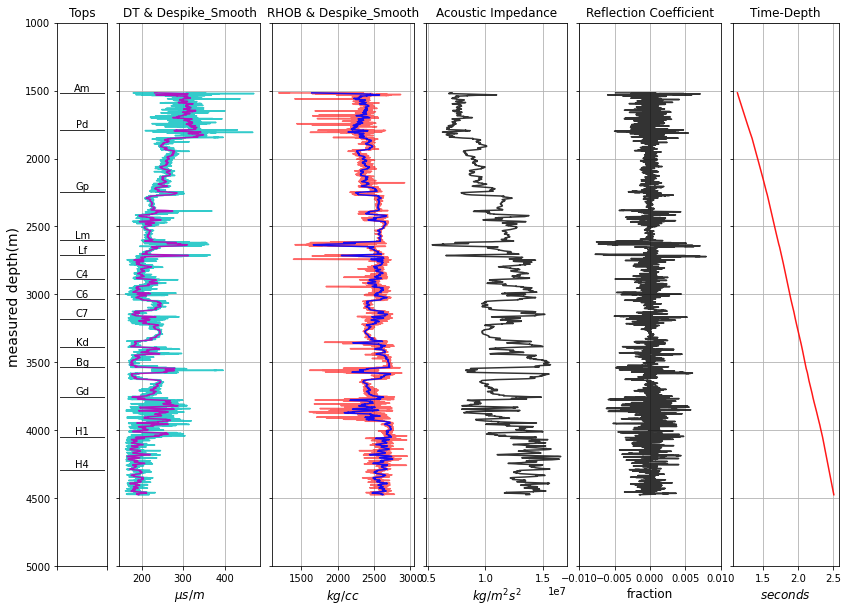

In [24]:
fig, axs = plt.subplots(1, 6, sharey=True, figsize = (14,10), gridspec_kw={'width_ratios': [0.7,2,2,2,2,1.5]})
fig.subplots_adjust(wspace=0.1)
# -----------------------------------------------------------------------------------track1------------
axs[0].set_title('Tops', style = 'normal')
axs[0].set_ylabel('measured depth(m) ', fontsize = '14' )
axs[0].set_xticklabels('')
for Top in tops_dept.values() :
    axs[0].axhline( y = float(Top), color = 'k', lw = 1,   
                            alpha = 0.8, xmin = 0.05, xmax = 0.95 )
for Top, MD in tops_dept.items():
    axs[0].text( x = 0.5,  y = float(MD), s = Top,fontsize = '10', 
                horizontalalignment = 'center',verticalalignment = 'bottom')
# -----------------------------------------------------------------------------------track2------------
axs[1].plot( df.DT, df.index,'c', alpha=0.8)
axs[1].plot( df.DT_DS_SM, df.index,'m', alpha=0.9)
axs[1].set_title('DT & Despike_Smooth', style = 'normal')
axs[1].set_xlabel( r'$\mu s/m $', fontsize = '12')
axs[1].set_ylim(1000, 5000)
axs[1].invert_yaxis()
axs[1].grid()
# -----------------------------------------------------------------------------------track3------------
axs[2].plot( df.RHOB, df.index,'r', alpha=0.6)
axs[2].plot( df.RHOB_DS_SM, df.index,'b', alpha=0.9)
axs[2].set_title('RHOB & Despike_Smooth', style = 'normal')
axs[2].set_xlabel('$kg/cc$', fontsize = '12')
axs[2].set_ylim(1000, 5000)
axs[2].invert_yaxis()
axs[2].grid()
# -----------------------------------------------------------------------------------track4------------  
axs[3].plot( df.AI, df.index,'k', alpha=0.8)
axs[3].set_title('Acoustic Impedance', style = 'normal')
axs[3].set_xlabel( r'$kg/m^2s^2$', fontsize = '12')
axs[3].set_ylim(1000, 5000)
axs[3].invert_yaxis()
axs[3].grid()
# -----------------------------------------------------------------------------------track5-----------
axs[4].plot( df.Rc, df.index,'k', alpha=0.8)
axs[4].set_title('Reflection Coefficient', style = 'normal')
axs[4].set_xlabel('fraction' , fontsize = '12')
axs[4].set_ylim(1000, 5000)
axs[4].set_xlim(-0.01, 0.01)
axs[4].invert_yaxis()
axs[4].grid()
# -----------------------------------------------------------------------------------track6------------
axs[5].plot( df.TWT, df.index,'r', alpha=0.9)
axs[5].set_title('Time-Depth', style = 'normal')
axs[5].set_xlabel( '$seconds$', fontsize = '12')
axs[5].set_ylim(1000, 5000)
axs[5].invert_yaxis()
# axs[5].set_yticklabels('')
axs[5].grid()
plt.savefig('Fig1.png', dpi=300)

#### Figure 2

In this figure, we will plot AI and colvolution results in time domain. We also have an access to real surface seismic tracess around a well that can juxtapose with synthetic seismogram to see how match with that data.

In [25]:
seismic_well_path = '/content/Synthetic_Seismogram/around_well_seismic.csv'
df_offset_seis= pd.read_csv(seismic_well_path)

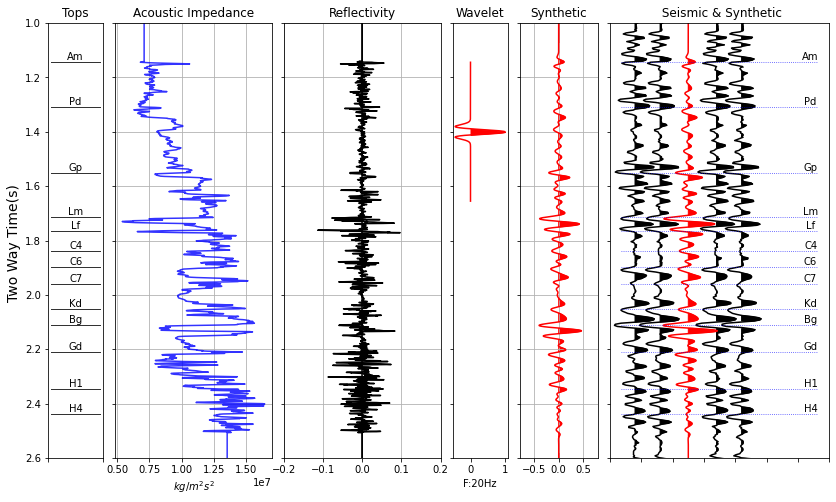

In [26]:
fig, axs = plt.subplots(1, 6, sharey=False, figsize = (14,8), gridspec_kw={'width_ratios': [0.7,2,2,0.7,1,2.8]})
fig.subplots_adjust(wspace=0.1)
# -----------------------------------------------------------------------------------track1------------
axs[0].set_title('Tops', style = 'normal')
axs[0].set_ylabel('Two Way Time(s) ', fontsize = '14' )
axs[0].set_xticklabels('')
axs[0].set_ylim(1 , 2.6)
axs[0].invert_yaxis()

for Top in tops_twt.values() :
    axs[0].axhline( y = float(Top), color = 'k', lw = 1,   
                            alpha = 0.8, xmin = 0.05, xmax = 0.95 )
for Top, S in tops_twt.items():
    axs[0].text( x = 0.5,  y = float(S), s = Top,fontsize = '10', 
                horizontalalignment = 'center',verticalalignment = 'bottom')
# -----------------------------------------------------------------------------------track2------------
axs[1].plot( AI_tdom, t,'b', alpha=0.8)
axs[1].set_title('Acoustic Impedance', style = 'normal')
axs[1].set_xlabel( r'$kg/m^2s^2$', fontsize = '10')
axs[1].set_ylim(1 , 2.6)
axs[1].set_yticklabels('')
axs[1].invert_yaxis()
axs[1].grid()
# -----------------------------------------------------------------------------------track3------------
axs[2].plot( Rc_tdom, t,'k')
axs[2].plot([0, 0], [t.min(), t.max()], '-', c='k')
axs[2].set_title('Reflectivity', style = 'normal')
axs[2].set_ylim(1 , 2.6)
axs[2].set_xlim(-0.2 , 0.2)
axs[2].set_yticklabels('')
axs[2].invert_yaxis()
axs[2].grid()
# -----------------------------------------------------------------------------------track4------------   
axs[3].plot( w, t0+1.4,'r', alpha=0.99)
axs[3].fill_betweenx(t0+1.4 , w,  0,  w > 0.0,  color='r')
axs[3].set_title('Wavelet', style = 'normal')
axs[3].set_xlabel('F:'+ str(f)+'Hz' , fontsize = '10')
axs[3].set_yticklabels('')
axs[3].set_ylim(1 , 2.6)
axs[3].invert_yaxis()
# -----------------------------------------------------------------------------------track5------------
axs[4].plot( synthetic, t ,'r')
axs[4].fill_betweenx(t, synthetic,  0,  synthetic > 0,  color='r')
axs[4].set_title('Synthetic', style = 'normal')
axs[4].set_ylim(1 , 2.6)
axs[4].set_xlim(-0.8 , 0.8)
axs[4].invert_yaxis()
axs[4].set_yticklabels('')
axs[4].grid()
# -----------------------------------------------------------------------------------track6------------
offsets=[0.4, 0.8 , 1.25, 1.7, 2.1]

x1= (df_offset_seis.cdp409.values/1e5) + offsets[0]
x2= (df_offset_seis.cdp410.values/1e5) + offsets[1]
x3= (df_offset_seis.cdp412.values/1e5) + offsets[3]
x4= (df_offset_seis.cdp413.values/1e5) + offsets[4]
t_sei=df_offset_seis.time

axs[5].plot( x1, t_sei ,'k')
axs[5].fill_betweenx(t_sei, offsets[0] , x1, where=(x1>offsets[0]),color='k')
axs[5].plot( x2, t_sei ,'k')
axs[5].fill_betweenx(t_sei, offsets[1] , x2, where=(x2>offsets[1]),color='k')
axs[5].plot( synthetic+offsets[2], t ,'r')
axs[5].fill_betweenx(t, offsets[2] , (synthetic+offsets[2]),
                     where=((synthetic+offsets[2])>offsets[2]),color='r')
axs[5].plot( x3, t_sei ,'k')
axs[5].fill_betweenx(t_sei, offsets[3] , x3, where=(x3>offsets[3]),color='k')
axs[5].plot( x4, t_sei ,'k')
axs[5].fill_betweenx(t_sei, offsets[4] , x4, where=(x4>offsets[4]),color='k')

axs[5].set_title(' Seismic & Synthetic', style = 'normal')
axs[5].set_yticklabels('')
axs[5].set_xticklabels('')
axs[5].set_ylim(1 , 2.6)
axs[5].set_xlim(0 , 03.5)
axs[5].invert_yaxis()
for Top in tops_twt.values() :
    axs[5].axhline( y = float(Top), color = 'b', lw = 0.8, ls = ':', 
                   alpha = 0.8, xmin = 0.05, xmax = 0.95 )
for Top, S in tops_twt.items():
    axs[5].text( x = 3.2,  y = float(S), s = Top,fontsize = '10', 
                horizontalalignment = 'center',verticalalignment = 'bottom')    

plt.savefig('Fig2.png', dpi=600)

### Refrences:<br>
[Agile geoscience and SEG WiKI](https://wiki.seg.org/wiki/Well_tie_calculus)